#**AI From scratch: Python, Scikit-Learn, Tensorflow/Keras**

the low-level approach
- is most flexible
- requires advanced coding and machine learning skills:
  - programming language that is common for ML: Python, Julia, R
  - a library of ML/DL models or building blocks (scikit learn, Keras, Pytorch, ...)
  - being up to date on the latest AI trends and achievements

# **Tensorflow Datasets**

**TensorFlow Datasets** is a group of datasets ready to use, with TensorFlow or other Python ML frameworks, such as Jax. All datasets can be used with tf.data.Datasets. This enables easy-to-use and high-performance input pipelines. To get started see the guide and our list of datasets. 

Guide: https://blog.tensorflow.org/2019/02/introducing-tensorflow-datasets.html

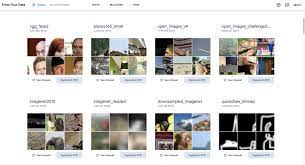

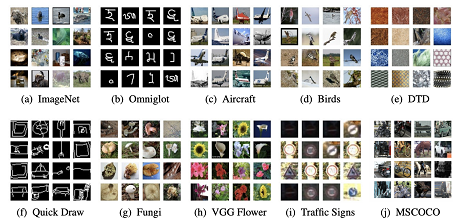

# **EuroSAT Dataset**

EuroSAT dataset is extracted from Sentinel-2 satellite images including up to 13 spectral bands. It is made of 10 classes with 27000 labeled and geo-referenced samples.

Two datasets are offered: - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image. - all: Contains all 13 bands in the original value range (float32).

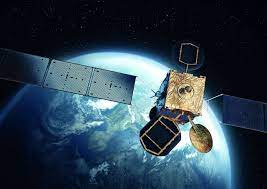

# **Satellite Image Classification**



For further reading and experimentation [A planetary-scale platform for Earth science data & analysis](https://earthengine.google.com/)

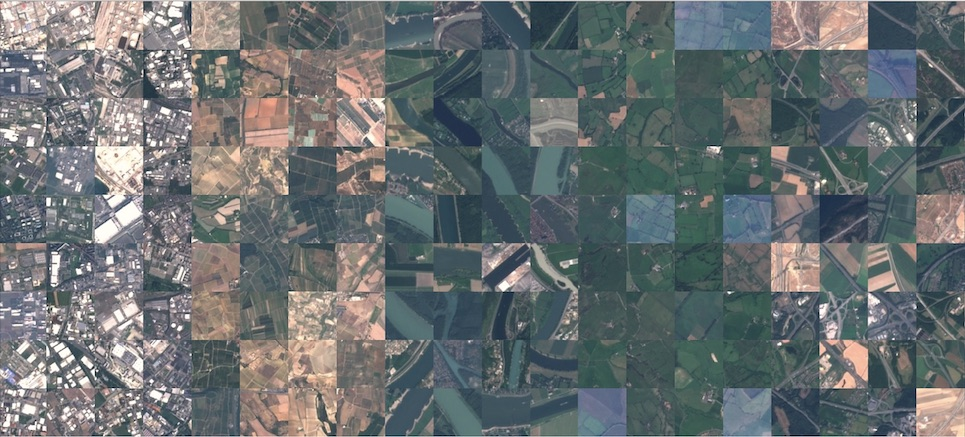

In [17]:
! pip install -qU tensorflow_datasets

# **All Imports**

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random as random

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Flatten, Dense, Dropout 
from keras.utils import np_utils

from keras.applications.resnet import ResNet50
from keras.applications.resnet import preprocess_input

import tensorflow_datasets as tfds

# **Download Data**

In [ ]:
ds, ds_info = tfds.load('eurosat/rgb', with_info=True, split='train', data_dir='.')

tfds.show_examples(ds, ds_info);

#**Load into Pandas**

In [ ]:
df = tfds.as_dataframe(ds, ds_info)
print(df.shape)

In [ ]:
df.sample(10)

#**Target Distribution**

In [ ]:
df.groupby('label')['label'].value_counts()

#**Image Dimensions**

In [ ]:
df['image'][0].shape

#**Train Test Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.stack(df['image'].values), np.stack(df['label'].values), test_size=0.333333, shuffle=True, random_state=10)
print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

#**OneHot Encode the Label**

In [ ]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

In [ ]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

#**Custom CNN**

In [ ]:
def cnn():
  model = keras.Sequential([
    BatchNormalization(input_shape=X_train[0].shape, name='norm_1'),
    Conv2D(16, (5, 5), padding='same', activation='relu', name='conv_1'),
    MaxPool2D(name='pool_1'),
    
    BatchNormalization(name='norm_2'),
    Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_2_a'),
    Conv2D(32, (3, 3), padding='same', activation='relu', name='conv_2_b'),
    MaxPool2D(name='pool_2'),
    
    BatchNormalization(name='norm_3'),
    Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_3_a'),
    Conv2D(64, (3, 3), padding='same', activation='relu', name='conv_3_b'),
    MaxPool2D(name='pool_3'),
    
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='dense_1'),
    Dropout(0.5, name='drop_1'),
    Dense(64, activation='relu', name='dense_2'),
    Dropout(0.5, name='drop_2'),
    Dense(10, activation='softmax', name='output')])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
model = cnn()
print(model.summary())

#**Model Training**

In [ ]:
%%time
model = cnn()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=2, # put 100 for best final accuracy 
    batch_size=512,
    verbose=1,
    callbacks=[early_stopping])

# **K-Fold Cross-Validation**

To evaluate our network while we keep adjusting its parameters (such as the number of epochs used for training), we could simply split the data into a training set and a validation set, as we were doing in our previous examples. However, because we have so few data points, the validation set would end up being very small (e.g. about 100 examples). A consequence is that our validation scores may change a lot depending on which data points we choose to use for validation and which we choose for training, i.e. the validation scores may have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use K-fold cross-validation. It consists of splitting the available data into K partitions (typically K=4 or 5), then instantiating K identical models, and training each one on K-1 partitions while evaluating on the remaining partition. The validation score for the model used would then be the average of the K validation scores obtained.

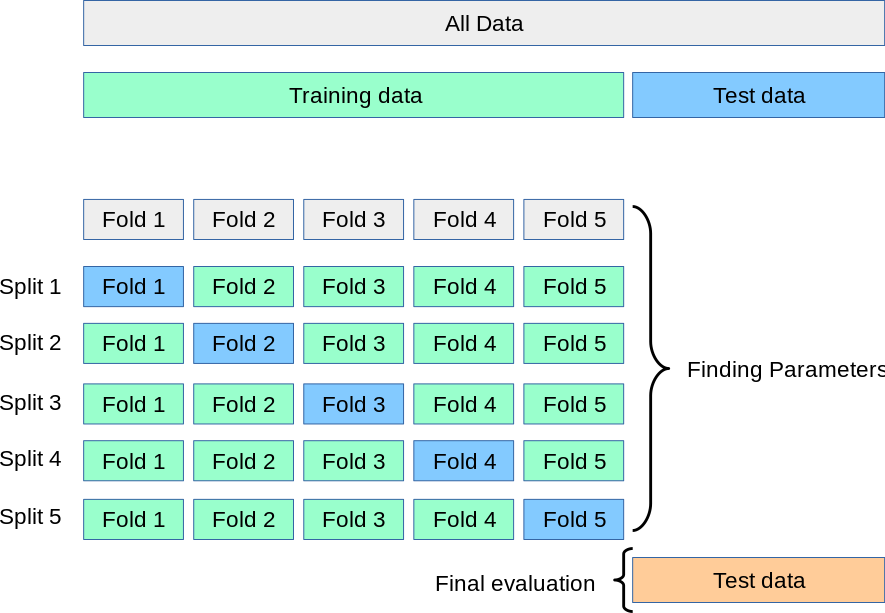

In [16]:
k = 3
num_val_samples = len(X_train) // k         
num_epochs = 2   # put 100 for best final accuracy 
all_scores = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = X_train[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = y_train[i * num_val_samples: (i + 1) * num_val_samples]

    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [X_train[:i * num_val_samples],
         X_train[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [y_train[:i * num_val_samples],
         y_train[(i + 1) * num_val_samples:]],
        axis=0)

    # Build the Keras model (already compiled)
    model = cnn()
    # Train the model (in silent mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets)
              epochs=num_epochs, batch_size=1, verbose=0)
    # Evaluate the model on the validation data
    val_mse, val_acc = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_acc)
    acc_history = history.history['val_accuracy']
    all_acc_histories.append(acc_history)    

processing fold # 0


KeyboardInterrupt: ignored

In [ ]:
print(all_scores)

In [ ]:
print(np.mean(all_scores))

In [ ]:
average_acc_history = [
    np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_acc_history) + 1), average_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation ACC')
plt.show()

In [ ]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_acc_history[10:])

plt.plot(range(1, len(smooth_acc_history) + 1), smooth_acc_history)
plt.xlabel('Epochs')
plt.ylabel('Validation ACC')
plt.show()

After this, tuning other parameters of our model (besides the number of epochs, we could also adjust the size of the hidden layers), we can train a final "production" model on all of the training data, with the best parameters, then look at its performance on the test data.

# **Evaluate Model Performance**

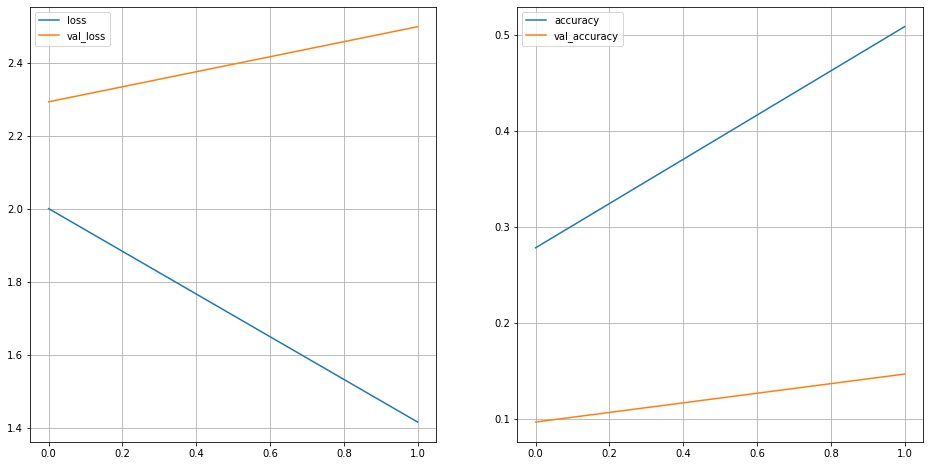

CNN Error: 85.28%


In [19]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

#**Inspect Errors**

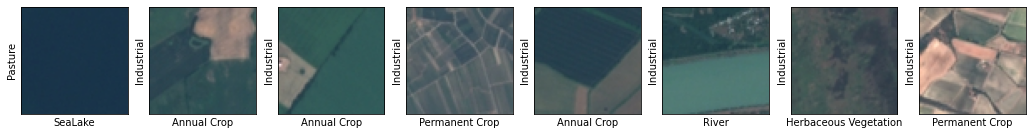

In [20]:
labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway', 'Industrial', 'Pasture', 'Permanent Crop', 'Residential', 'River', 'SeaLake']

N = 8
fig, ax = plt.subplots(1, N, figsize=(18, 4))
predictions = []
while len(predictions) < N:
  i = random.randint(0, X_test.shape[0])
  if (np.argmax(model.predict(X_test[i].reshape(1, *X_test[i].shape))) != np.argmax(y_test[i])):
    predictions.append(np.argmax(model.predict(X_test[i].reshape(1, *X_test[i].shape))))
    ax[len(predictions)-1].imshow(X_test[i])

    ax[len(predictions)-1].set_xlabel(labels[np.argmax(y_test[i])])
    ax[len(predictions)-1].set_xticks([])

    ax[len(predictions)-1].set_ylabel(labels[predictions[-1]])
    ax[len(predictions)-1].set_yticks([])
plt.show()

In [21]:
del model
del df_history

In [22]:
del df
del ds

#**Transfer Learning**

#**Headless & customized pretrained ResNet50**

In [24]:
model_base = ResNet50(include_top=False,
                      pooling='avg',
                      input_tensor=layers.Input(shape=(128, 128, 3)))
model_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

#**New Head**

In [25]:
def resnet():
  model_base.trainable = False

  model = keras.Sequential([
      model_base,
      layers.Flatten(),
      layers.Dense(128, activation='relu', name='dense_1'),
      layers.Dropout(0.5, name='drop_1'),
      layers.Dense(64, activation='relu', name='dense_2'),
      layers.Dropout(0.5, name='drop_2'),
      layers.Dense(10, activation='softmax', name='output')
  ])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

#**Preprocess & upscale Data**

In [26]:
X_train = preprocess_input(X_train).repeat(2, axis=1).repeat(2, axis=2)
X_test = preprocess_input(X_test).repeat(2, axis=1).repeat(2, axis=2)

print('Train: ', X_train.shape, y_train.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (18000, 128, 128, 3) (18000, 10)
Test:  (9000, 128, 128, 3) (9000, 10)


### Train Model

In [1]:
%%time
model = resnet()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.15,
    epochs=2, # put 100 for best final accuracy 
    batch_size=256,
    verbose=1,
    callbacks=[early_stopping])

NameError: ignored

#**Evaluate Model Performance**

In [ ]:
del X_train

In [ ]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test, y_test, verbose=0)
print("ResNet Error: %.2f%%" % (100-scores[1]*100))